In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
#im skipping leap days currently in multiple places
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn
import random
import json
import pickle
import time
import copy

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
#ercot 2017 loads

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")

testloads = np.array(list(ercot2017['ERCOT']))

In [75]:
startdate = datetime.datetime(year=2010, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

allhours = []

while curr < enddate:
    allhours.append(curr)
    curr += datetime.timedelta(hours=1)
    
trainhours = np.array(allhours[0:-8760]) #all but last year, not a leap year
testhours = np.array(allhours[-8760:])

#get indecies of day starts in testhours
startdate = datetime.datetime(year=2017, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

day_start_i = []
i = 0

while curr < enddate:
    if curr.hour == 0:
        day_start_i.append(i)
    curr += datetime.timedelta(hours=1)
    i += 1


array([datetime.datetime(2017, 7, 28, 15, 0),
       datetime.datetime(2017, 7, 28, 16, 0),
       datetime.datetime(2017, 7, 28, 14, 0),
       datetime.datetime(2017, 7, 20, 15, 0),
       datetime.datetime(2017, 7, 27, 15, 0)], dtype=object)

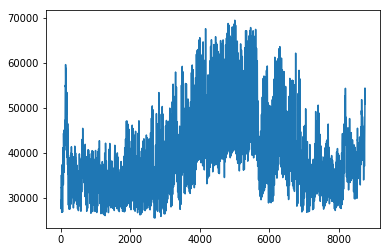

In [41]:
#July peak was calculated to have occured at datetime.datetime(2017, 7, 28, 17, 0)

plt.plot(testloads)
testhours[testloads.argsort()[-5:][::-1]]

In [51]:
#percentage difference in top two
print(testloads.argsort()[-4:][::-1])
testloads[5007] - testloads[4815] #largest loads exceeds second largest load by 722.3 MW

#average peak was 67,273.1 MW
print(722.3/67273.1) 

#1% of load reduction would result in peak time shift, so I can consider a business using up to approx 700 MW in 2017 without annual peak occuring at some other time

#per ERCOT Day-ahead load forecast error for July was 2.27%

[5007 5008 5006 4815]
0.010736832404036679


In [59]:
#lmps
xls = pd.ExcelFile(path + "LMPS/rpt.00013060.0000000000000000.DAMLZHBSPP_2016.xlsx")
sheets_2016 = ["Jan_1", "Feb_2", "Mar_3", "Apr_4", "May_5", "Jun_6", "Jul_7", "Aug_8", "Sep_9", "Oct_10", "Nov_11", "Dec_12"]
hourly_lmp_2016 = []
for sheet in sheets_2016:
    lmps = pd.read_excel(xls, sheet)
    for i in range(len(lmps['Settlement Point Price'])):
        if lmps['Settlement Point'][i] == 'HB_BUSAVG':
            hourly_lmp_2016.append(lmps['Settlement Point Price'][i])
            
xls = pd.ExcelFile(path + "LMPS/rpt.00013060.0000000000000000.DAMLZHBSPP_2017.xlsx")
sheets_2017 = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
hourly_lmp = []
for sheet in sheets_2017:
    lmps = pd.read_excel(xls, sheet)
    for i in range(len(lmps['Settlement Point Price'])):
        if lmps['Settlement Point'][i] == 'HB_BUSAVG':
            hourly_lmp.append(lmps['Settlement Point Price'][i])
            
hourly_lmp = np.array(hourly_lmp)

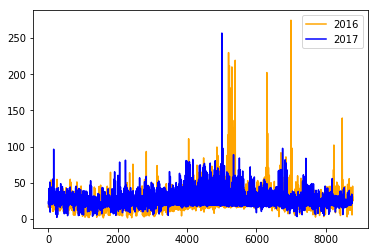

In [60]:
#per megawatt price
plt.plot(hourly_lmp_2016, color="orange", label="2016")
plt.plot(hourly_lmp, color="blue", label="2017")
plt.legend()

In [53]:
#peak lmp's occured 
print(hourly_lmp[[5007, 5008, 5006]])

[206.47  59.55 257.04]


In [43]:
testhours[hourly_lmp.argsort()[-5:][::-1]]

array([datetime.datetime(2017, 7, 28, 14, 0),
       datetime.datetime(2017, 7, 28, 15, 0),
       datetime.datetime(2017, 7, 28, 13, 0),
       datetime.datetime(2017, 7, 29, 14, 0),
       datetime.datetime(2017, 10, 9, 14, 0)], dtype=object)

In [61]:
#concave utility function from 0 to 500 MW
#500 MW at $2150 per MW CP costs = 1.075mil per annum
#maximum daily utility set equal to transmission costs
#17.5(x)(500 - x) - (pi_e + pi_cp)x = y utility
#-17.5x^2 + [8750 - (pi_e + pi_cp)]x = y
#dy/dx = -35x + [8750 - (pi_e + pi_cp)], max x = [8750 - (pi_e + pi_cp)]/35


cp_perMW = 2150.0

In [170]:
def hourly_utility(power, pi_e, pi_cp):
    utility = -17.5*np.power(power, 2) + (8750.0 - (pi_e + pi_cp))*power
    return(utility)

def max_power(pi_e, pi_cp):
    max_pow = (8750.0 - (pi_e + pi_cp))/35.0
    return(max_pow)

def cp_curtailment(cdfval, min_thresh=0.85):
    #returns a fractional curtailment of power demand as a function
    #of predicted CDF value of load
    curtail_val = (cdfval - min_thresh)/(1 - min_thresh)
    outval = np.min([0, curtail_val])
    return(outval)

In [166]:
#perfect knowledge optimal performance during workday

ann_util_opt = 0.0

for i in range(len(testhours)):
    dt = testhours[i]
    if dt.hour in [9, 10, 11, 12, 13, 14, 15, 16]:
        #pi_e = hourly_lmp[i]
        if i == 5007: #CP:
            pi_cp = 2150.0
            mp = max_power(pi_e, pi_cp)
        else:
            pi_cp = 0.0
            mp = max_power(pi_e, pi_cp)

            ann_util_opt += hourly_utility(mp, pi_e, pi_cp)

print(ann_util_opt)

#for each hour
    #calculate max_power, include CP price if annual CP (check that this returns a non-negative value)
    #add utility to annual sum

2919.0


In [245]:
#perfect knowledge optimal performance during workday
#marginal utility model

alphas = np.arange(0.85, 0.995, 0.005)

perfect = []

for a in alphas:
    ann_util_opt = 0.0

    for i in range(len(testhours)):
        dt = testhours[i]
        #if dt.hour in [i for i in range(24)]:
        if dt.hour in [9, 10, 11, 12, 13, 14, 15, 16]:
            if i == 5007: #CP:
                pass
            else:
                ann_util_opt += 1

    perfect.append(ann_util_opt)


In [ ]:
#generate historical average model

570.2781314827672 36556.57900951147


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


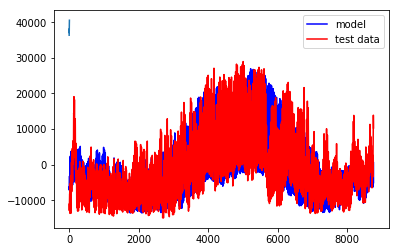

In [168]:
#ERCOT data
lds = datetime.datetime(year=2016, month=2, day=29, hour=0, minute=0) #lines 1415 to 1439
lde = datetime.datetime(year=2016, month=2, day=29, hour=23, minute=0)

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")
ercot2016 = pd.read_excel(path + "native_Load_2016.xlsx") #leap year
ercot2016.drop(ercot2016.index[1415:1439], inplace=True) #dropping leap days so years line up

ercot2015 = pd.read_excel(path + "native_Load_2015.xls")
ercot2014 = pd.read_excel(path + "2014_ERCOT_Hourly_Load_Data.xls")
ercot2013 = pd.read_excel(path + "2013_ERCOT_Hourly_Load_Data.xls")
ercot2012 = pd.read_excel(path + "2012_ERCOT_Hourly_Load_Data.xls") #leap year
ercot2012.drop(ercot2012.index[1415:1439], inplace=True)

ercot2011 = pd.read_excel(path + "2011_ERCOT_Hourly_Load_Data.xls")
ercot2010 = pd.read_excel(path + "2010_ERCOT_Hourly_Load_Data.xls")

yearly_data = [ercot2010, ercot2011, ercot2012, ercot2013, ercot2014, ercot2015, ercot2016, ercot2017]
training = [list(ercot2010['ERCOT']), list(ercot2011['ERCOT']), list(ercot2012['ERCOT']), list(ercot2013['ERCOT']), list(ercot2014['ERCOT']), list(ercot2015['ERCOT']), list(ercot2016['ERCOT'])]
means = [ np.nanmean(y) for y in training ]

#use system-wide loadgrowth for all regions
A = np.vstack((np.array([0, 1, 2, 3, 4, 5, 6]), np.array([1, 1, 1, 1, 1, 1, 1]))).T
a, b = np.linalg.lstsq(A, np.array(means))[0]
print(a, b)
projected_mean = a*7.0 + b
plt.plot(means + [projected_mean])
means.append(projected_mean)
load_growth = np.array(means)

yearly_loads = np.zeros((8,8760))

for i in range(len(yearly_data)):
    yearly_loads[i,:] = np.array(yearly_data[i]['ERCOT']) - load_growth[i]
    
model = np.nanmean(yearly_loads[0:6,:], axis=0)
test = yearly_loads[7,:]
plt.plot(model, color="blue", label="model")
plt.plot(test, color="red", label="test data")
plt.legend()
plt.show()

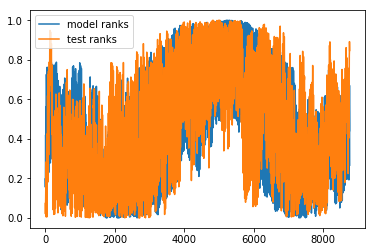

In [169]:
model_ranks = np.zeros((yearly_loads.shape[1], 1))
test_ranks = np.zeros((yearly_loads.shape[1], 1))

for i in range(model_ranks.shape[0]):
    greater = np.sum([ 1 for k in model[:,] if k >= model[i,] ])/float(model.shape[0])
    model_ranks[i,0] = 1.0 - greater
    
for i in range(test_ranks.shape[0]):
    greater = np.sum([ 1 for k in test[:,] if k >= test[i,] ])/float(test.shape[0])
    test_ranks[i,0] = 1.0 - greater
    
plt.plot(model_ranks, label="model ranks")
plt.plot(test_ranks, label="test ranks")
plt.legend()

In [155]:
for i in range(9,17):
    print(i)

9
10
11
12
13
14
15
16


In [160]:
ann_util = 0.0

for i in day_start_i:
    dt = testhours[i]
    cdf_vals = model_ranks[i:i+24]
    #for h in range(24):
    for h in range(9,17):
        g += 1
        ann_hour = i+h
        pi_e = hourly_lmp[ann_hour]
        mp = max_power(pi_e, 0.0)
        curtail_mp = cp_curtailment(cdf_vals[h])
        rp = curtail_mp * mp
        if ann_hour == 5007:
            #cp occurence
            pi_cp = 2150.0
        else:
            pi_cp = 0.0
            
        ann_util += hourly_utility(rp, pi_e, pi_cp)
        
print(ann_util/ann_util_opt)

0.911508616716043


In [188]:
alphas

array([0.85 , 0.855, 0.86 , 0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 ,
       0.895, 0.9  , 0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935,
       0.94 , 0.945, 0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 ,
       0.985, 0.99 , 0.995, 1.   ])

In [244]:
#marginal utility model
def cp_curtailment(cdfval, min_thresh=0.85):
    #returns a fractional curtailment of power demand as a function
    #of predicted CDF value of load
    curtail_val = (cdfval - min_thresh)/(1 - min_thresh)
    outval = np.max([0, curtail_val])
    return(outval)

historical_by_alpha = []

for a in alphas:
    ann_util = 0.0

    for i in day_start_i:
        dt = testhours[i]
        cdf_vals = model_ranks[i:i+24]
        #for h in range(24):
        for h in range(9,17):
            ann_hour = i+h
            curtail_mp = 1.0 - cp_curtailment(cdf_vals[h], min_thresh=a)
            if ann_hour == 5007:
                ann_util += curtail_mp*(-100.0)
            else:
                ann_util += curtail_mp

    #print(ann_util/ann_util_opt)
    historical_by_alpha.append(ann_util)

In [143]:
#neural net model
#with weather data
def torch_reshape_data(databatch):
    #flattens array inputs for a single list of training, target pairs
    inputs = []
    labels = []
    for sample in databatch:
        inputs.append(sample[0].flatten())
        labels.append(sample[1].flatten())
    return(torch.Tensor(np.asarray(inputs)), torch.Tensor(np.asarray(labels)))

path = "/home/chase/projects/peakload/data/nets/models/"
mname = 'triple_hidden_2593.pt'

sys.path.append("/home/chase/projects/peakload/src/python/nets/triple_hidden")

nnmodel = torch.load(path + mname)

random.seed(45) #fixed for all experiments, my high school football jersey number
torch.manual_seed(45)

test_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/regional_formatted/load_features/test"
files = os.listdir(test_data_path)
weather_normed_test_data_pairs = []
for f in files:
    with open(test_data_path + "/" + f, 'rb') as d:
        weather_normed_test_data_pairs.append(pickle.load(d))

In [144]:
day_pairs = []

for i in day_start_i:
    try:
        day_pairs.append(weather_normed_test_data_pairs[i])
    except:
        pass

In [145]:
#do prediction on test data
inputs, labels = torch_reshape_data(day_pairs)
labels = Variable(labels.cuda())
inputs = Variable(inputs.cuda())
outputs = nnmodel(inputs)
    
labels = labels.data.cpu().numpy()
outputs = outputs.data.cpu().numpy()

In [161]:
nn_ann_util = 0.0
hourly_utils = []

j = 0
for i in day_start_i:
    dt = testhours[i]
    if j == 364:
        break
    cdf_vals = outputs[j,:]
    #for h in range(24):
    for h in range(9,17):
        ann_hour = i+h
        pi_e = hourly_lmp[ann_hour]
        mp = max_power(pi_e, 0.0)
        curtail_mp = cp_curtailment(cdf_vals[h])
        rp = curtail_mp * mp
        if ann_hour == 5007:
            #cp occurence
            pi_cp = 2150.0
        else:
            pi_cp = 0.0
            
        nn_ann_util += hourly_utility(rp, pi_e, pi_cp)
        hourly_utils.append(hourly_utility(rp, pi_e, pi_cp))
    j += 1

print((nn_ann_util + 24*np.mean(hourly_utils))/ann_util_opt)

0.9701981009873685


In [262]:
#marginal utility model

nn_by_alpha = []

for a in alphas:
    nn_ann_util = 0.0
    hourly_utils = []

    j = 0
    for i in day_start_i:
        dt = testhours[i]
        if j == 364:
            nn_ann_util += 1
            break
        cdf_vals = outputs[j,:]
        #for h in range(24):
        for h in range(9,17):
            ann_hour = i+h
            curtail_mp = 1.0 - cp_curtailment(cdf_vals[h], min_thresh=a)
            if curtail_mp < 0.0:
                curtail_mp = 0.0
                #print("over")
            if ann_hour == 5007:
                nn_ann_util += curtail_mp*(-100.0)
            else:
                nn_ann_util += curtail_mp

        j += 1

    nn_by_alpha.append(nn_ann_util)
    #print(nn_ann_util/ann_util_opt)

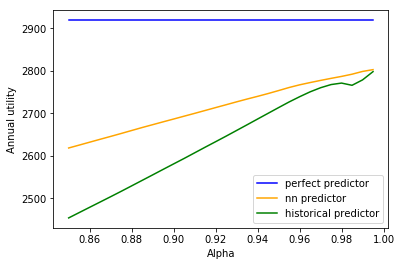

In [263]:
plt.plot(alphas, perfect, color="blue", label="perfect predictor")
plt.plot(alphas, nn_by_alpha, color="orange", label="nn predictor")
plt.plot(alphas, historical_by_alpha, color="green", label="historical predictor")
plt.xlabel("Alpha")
plt.ylabel("Annual utility")
#plt.ylim(2000,3500)

plt.legend()

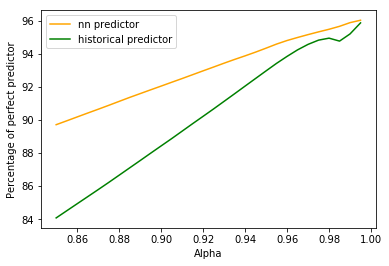

In [264]:
#plt.plot(alphas, perfect, color="blue", label="perfect predictor")
plt.plot(alphas, (np.array(nn_by_alpha)/np.array(perfect))*100, color="orange", label="nn predictor")
plt.plot(alphas, (np.array(historical_by_alpha)/np.array(perfect))*100, color="green", label="historical predictor")
plt.xlabel("Alpha")
plt.ylabel("Percentage of perfect predictor")
#plt.ylim(80,100)
#plt.xlim(0, 1)
plt.legend()

In [265]:
np.array(nn_by_alpha) - np.array(historical_by_alpha)

array([164.39365276, 158.65901457, 153.05448354, 147.4681012 ,
       141.73289468, 135.98624375, 130.14553352, 124.25261565,
       118.0488436 , 111.76039037, 105.48926796,  99.37689364,
        92.79715858,  86.38201838,  80.20219196,  73.84158459,
        67.28574958,  60.50271333,  53.32544268,  46.47291239,
        40.05281145,  33.99281494,  27.99439157,  21.82494343,
        17.20776644,  14.57980524,  15.67261826,  26.07204262,
        19.88542652,   4.67090816])